## Importing packages and dataset

In [ ]:
import json
import os
import numpy as np
import torch
import gdown
import torch
import torch.nn as nn
import math
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn.functional as F
from ray import tune


def grid_to_tensor(grid):
    grid_np = np.array(grid, dtype=np.int64)
    grid_tensor = torch.tensor(grid_np, dtype=torch.long)
    return grid_tensor

def process_json_data_to_dict(challenges_data, solutions_data, output_dir):
    data_dict = {}

    for task_id, task_data in challenges_data.items():
        data_dict[task_id] = []

        for example in task_data.get("train", []):
            input_tensor = grid_to_tensor(example["input"])
            output_tensor = grid_to_tensor(example["output"])
            data_dict[task_id].append((input_tensor, output_tensor))

        test_solutions = solutions_data.get(task_id, [])
        for i, example in enumerate(task_data.get("test", [])):
            input_tensor = grid_to_tensor(example["input"])

            if i < len(test_solutions):
                output_tensor = grid_to_tensor(test_solutions[i])
            else:
                output_tensor = None
            data_dict[task_id].append((input_tensor, output_tensor))

    save_path = os.path.join(output_dir, "grouped_data_by_task.pt")
    torch.save(data_dict, save_path)
    print(f"Data saved to {save_path} grouped by task_id.")

url_challenges = "https://drive.google.com/uc?id=1humrcrnvRKvmfnd-GKxNA76oUvdQ7JO-"
url_solutions = "https://drive.google.com/uc?id=1GAHQwLAaPRMq9tqHwlU1WBeeJmNJ4grx"

url_eval_challenges = "https://drive.google.com/uc?export=download&id=1E8fjyXyOyd_MG5UgjgyybvR1mKpLeiF4"
url_eval_solutions = "https://drive.google.com/uc?export=download&id=1Cdx0w80IfN9r5YPwGje2KDkV1XCR46w-"


challenges_file = "challenges_data.json"
solutions_file = "solutions_data.json"
eval_challenges_file = "eval_challenges_data.json"
eval_solutions_file = "eval_solutions_data.json"
gdown.download(url_challenges, challenges_file, quiet=False)
gdown.download(url_solutions, solutions_file, quiet=False)
gdown.download(url_eval_challenges, eval_challenges_file, quiet=False)
gdown.download(url_eval_solutions, eval_solutions_file, quiet=False)

with open(challenges_file, "r") as file:
    challenges_data = json.load(file)
with open(solutions_file, "r") as file:
    solutions_data = json.load(file)

with open(eval_challenges_file, "r") as file:
    eval_challenges_data = json.load(file)
with open(eval_solutions_file, "r") as file:
    eval_solutions_data = json.load(file)


output_directory = "cnn_dataset"
os.makedirs(output_directory, exist_ok=True)

eval_output_directory = "eval_cnn_dataset"
os.makedirs(eval_output_directory, exist_ok=True)

process_json_data_to_dict(challenges_data, solutions_data, output_directory)
process_json_data_to_dict(eval_challenges_data, eval_solutions_data, eval_output_directory)

Downloading...
From: https://drive.google.com/uc?id=1humrcrnvRKvmfnd-GKxNA76oUvdQ7JO-
To: /content/challenges_data.json
100%|██████████| 1.27M/1.27M [00:00<00:00, 50.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1GAHQwLAaPRMq9tqHwlU1WBeeJmNJ4grx
To: /content/solutions_data.json
100%|██████████| 185k/185k [00:00<00:00, 58.3MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1E8fjyXyOyd_MG5UgjgyybvR1mKpLeiF4
To: /content/eval_challenges_data.json
100%|██████████| 2.06M/2.06M [00:00<00:00, 194MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1Cdx0w80IfN9r5YPwGje2KDkV1XCR46w-
To: /content/eval_solutions_data.json
100%|██████████| 313k/313k [00:00<00:00, 70.6MB/s]


Data saved to cnn_dataset/grouped_data_by_task.pt grouped by task_id.
Data saved to eval_cnn_dataset/grouped_data_by_task.pt grouped by task_id.


## Adding padding to all data and creating dataloaders

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

class GridDataset(Dataset):
    def __init__(self, data_path, target_size=(30, 30), frame_value=0):
        data = torch.load(data_path)
        self.tasks = list(data.values())
        self.target_size = target_size
        self.frame_value = frame_value

    def __len__(self):
        return len(self.tasks)

    def pad_to_target_size(self, tensor):
        height, width = tensor.shape
        pad_top = (self.target_size[0] - height) // 2
        pad_bottom = self.target_size[0] - height - pad_top
        pad_left = (self.target_size[1] - width) // 2
        pad_right = self.target_size[1] - width - pad_left

        padded_tensor = F.pad(tensor, (pad_left, pad_right, pad_top, pad_bottom), mode='constant', value=self.frame_value)
        return padded_tensor

    def __getitem__(self, idx):
        task_data = self.tasks[idx]
        inputs = []
        outputs = []

        for input_grid, output_grid in task_data:
            input_tensor = input_grid + 1
            input_padded = self.pad_to_target_size(input_tensor)
            inputs.append(input_padded)

            if output_grid is not None:
                output_tensor = output_grid + 1
                output_padded = self.pad_to_target_size(output_tensor)
                outputs.append(output_padded)
            else:
                outputs.append(None)

        return torch.stack(inputs), torch.stack([o for o in outputs if o is not None]) if outputs else torch.empty(0)

def custom_collate(batch):
    inputs, outputs = zip(*batch)
    return inputs, outputs

# Usage example
data_path = "cnn_dataset/grouped_data_by_task.pt"
dataset = GridDataset(data_path)
train_loader = DataLoader(dataset, batch_size=1, shuffle=True, collate_fn=custom_collate)

eval_data_path = "cnn_dataset/grouped_data_by_task.pt"
eval_dataset = GridDataset(data_path)
eval_loader = DataLoader(dataset, batch_size=1, shuffle=True, collate_fn=custom_collate)


<ipython-input-2-d7e71b266a97>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(data_path)


## Defining Models

In [ ]:
import torch
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt

class Model1(nn.Module):
    def __init__(self, d_model=32, nhead=4, num_encoder_layers=2, dropout = 0.1, train_lr=0.001, eval_lr=0.0001, kernell_size=3, device='cuda'):
        super(Model1, self).__init__()
        self.device = device
        self.relu = nn.ReLU()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(8)
        self.bn2 = nn.BatchNorm2d(16)
        self.bn3 = nn.BatchNorm2d(32)

        self.d_model = d_model
        self.num_heads = nhead
        self.num_layers = num_encoder_layers
        self.dropout = dropout
        self.num_classes = 11

        encoder_layer = nn.TransformerEncoderLayer(d_model=self.d_model,
                                                   nhead=self.num_heads,
                                                   dropout=self.dropout,
                                                   batch_first=True)

        self.transformer_encoder = nn.TransformerEncoder(encoder_layer,
                                                         num_layers=self.num_layers)

        self.classifier = nn.Linear(self.d_model, self.num_classes)

        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.Adam(self.parameters(), lr=train_lr)

        self.all_train_loss = []
        self.all_train_accuracy = []

        self.test_train_loss = []
        self.test_train_accuracy = []

        self.all_eval_loss = []
        self.all_eval_accuracy = []

        self.test_eval_loss = []
        self.test_eval_accuracy = []

        self.to_freeze = [self.conv1, self.conv2, self.conv3, self.bn1, self.bn2, self.bn3]

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.relu(self.bn3(self.conv3(x)))

        N, C, H, W = x.size()
        x = x.permute(0, 2, 3, 1).contiguous().view(N, H*W, C)

        x = self.transformer_encoder(x)

        x = self.classifier(x)
        x = x.permute(0, 2, 1)
        return x

    def visualize_predic(self, x_example, predict, y_example):
        predicted_classes = torch.argmax(predict, dim=1)
        x_example = x_example.squeeze()
        predict = predicted_classes[0].view(30, 30)
        target = y_example.view(30, 30)

        input_image = x_example.squeeze()
        predicted_image = predict.squeeze()
        target_image = target.squeeze()

        fig, axes = plt.subplots(1, 3, figsize=(9, 3))

        axes[0].imshow(input_image.cpu())
        axes[0].set_title("Input Image")
        axes[0].axis("off")

        axes[1].imshow(predicted_image.cpu())
        axes[1].set_title("Predicted Output")
        axes[1].axis("off")

        axes[2].imshow(target_image.cpu(), cmap='gray')
        axes[2].set_title("Target Output")
        axes[2].axis("off")
        plt.show()

    def freeze_layers(self):
        for layer in self.to_freeze:
            for param in layer.parameters():
                param.requires_grad = False

    def unfreeze_layers(self):
        for layer in self.to_freeze:
            for param in layer.parameters():
                param.requires_grad = True

    def calculate_accuracy(self, prediction, target):
        predicted_classes = torch.argmax(prediction, dim=1)
        correct_predictions = (predicted_classes == target).sum().item()
        accuracy_percentage = (correct_predictions / target.numel()) * 100
        return accuracy_percentage

    def train_model(self, train_loader, val=False, repetitions=1, visualize=False, train_lr=0.001, eval_lr=0.0001):
        self.to(self.device)
        if val:
            self.freeze_layers()
            for param_group in self.optimizer.param_groups:
                param_group['lr'] = eval_lr
        else:
            self.unfreeze_layers()
            for param_group in self.optimizer.param_groups:
                param_group['lr'] = train_lr

        for batch in tqdm(train_loader):
            x_task, y_task = batch[0][0], batch[1][0]
            x_test, y_test = x_task[-1], y_task[-1]
            x_task, y_task = x_task[:-1], y_task[:-1]

            for i in range(repetitions):
                for x_example, y_example in zip(x_task, y_task):
                    x = x_example.unsqueeze(0).unsqueeze(0).float().to(self.device)
                    y = y_example.long().to(self.device).view(1, 900)
                    predict = self(x)


                    pred_reshaped = predict.permute(0, 2, 1).contiguous().view(-1, self.num_classes)
                    y_reshaped = y.view(-1)

                    loss = self.criterion(pred_reshaped, y_reshaped)
                    acc = self.calculate_accuracy(predict, y)

                    if val:
                        self.all_eval_loss.append(loss.item())
                        self.all_eval_accuracy.append(acc)
                    else:
                        self.all_train_loss.append(loss.item())
                        self.all_train_accuracy.append(acc)

                    loss.backward()
                    self.optimizer.step()
                    self.optimizer.zero_grad()


            x_test = x_test.unsqueeze(0).unsqueeze(0).float().to(self.device)
            y_test = y_test.long().to(self.device).view(1, 900)
            predict = self(x_test)

            pred_reshaped = predict.permute(0, 2, 1).contiguous().view(-1, self.num_classes)
            y_test_reshaped = y_test.view(-1)

            loss = self.criterion(pred_reshaped, y_test_reshaped)
            acc = self.calculate_accuracy(predict, y_test)

            if val:
                self.test_eval_loss.append(loss.item())
                self.test_eval_accuracy.append(acc)
                self.all_eval_loss.append(loss.item())
                self.all_eval_accuracy.append(acc)
            else:
                self.test_train_loss.append(loss.item())
                self.test_train_accuracy.append(acc)
                self.all_train_loss.append(loss.item())
                self.all_train_accuracy.append(acc)

            if visualize:
                with torch.no_grad():
                    self.visualize_predic(x_test, predict, y_test)


In [ ]:
class InceptionModule(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(InceptionModule, self).__init__()
        self.branch1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=5, padding=2),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

        self.branch4 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=7, padding=3),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)
        return torch.cat([branch1, branch2, branch3, branch4], dim=1)

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        residual = x
        x = self.relu(self.bn1(self.conv1(x)))
        return x + residual

class Model2(nn.Module):
    def __init__(self, d_model=32, nhead=4, num_encoder_layers=2, dropout = 0.1, train_lr=0.001, eval_lr=0.0001, kernell_size=3, device='cuda'):
        super(Model2, self).__init__()
        self.device = device
        self.relu = nn.ReLU()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=kernell_size, padding=1)
        self.bn1 = nn.BatchNorm2d(16)

        self.residual1 = ResidualBlock(16, 16)
        self.inception1 = InceptionModule(16, 8)
        self.dropout1 = nn.Dropout(p=0.3)

        self.residual2 = ResidualBlock(32, 32)
        self.inception2 = InceptionModule(32, 16)
        self.dropout2 = nn.Dropout(p=0.3)

        self.residual3 = ResidualBlock(64, 64)
        self.inception3 = InceptionModule(64, 8)
        self.dropout3 = nn.Dropout(p=0.3)

        self.d_model = d_model


        self.d_model = d_model
        self.num_heads = nhead
        self.num_layers = num_encoder_layers
        self.dropout = dropout
        self.num_classes = 11

        encoder_layer = nn.TransformerEncoderLayer(d_model=self.d_model,
                                                   nhead=self.num_heads,
                                                   dropout=self.dropout,
                                                   batch_first=True)

        self.transformer_encoder = nn.TransformerEncoder(encoder_layer,
                                                         num_layers=self.num_layers)

        self.classifier = nn.Linear(self.d_model, self.num_classes)

        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.Adam(self.parameters(), lr=train_lr)

        self.all_train_loss = []
        self.all_train_accuracy = []

        self.test_train_loss = []
        self.test_train_accuracy = []

        self.all_eval_loss = []
        self.all_eval_accuracy = []

        self.test_eval_loss = []
        self.test_eval_accuracy = []

        self.to_freeze = [self.conv1, self.bn1, self.residual1, self.inception1, self.dropout1,
                         self.residual2, self.inception2, self.dropout2,
                         self.residual3, self.inception3, self.dropout3]

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))

        x = self.residual1(x)
        x = self.inception1(x)
        x = self.dropout1(x)

        x = self.residual2(x)
        x = self.inception2(x)
        x = self.dropout2(x)

        x = self.residual3(x)
        x = self.inception3(x)
        x = self.dropout3(x)


        N, C, H, W = x.size()

        x = x.permute(0, 2, 3, 1).contiguous().view(N, H*W, C)


        x = self.transformer_encoder(x)


        x = self.classifier(x)
        x = x.permute(0, 2, 1)
        return x

    def visualize_predic(self, x_example, predict, y_example):
        predicted_classes = torch.argmax(predict, dim=1)
        x_example = x_example.squeeze()
        predict = predicted_classes[0].view(30, 30)
        target = y_example.view(30, 30)

        input_image = x_example.squeeze()
        predicted_image = predict.squeeze()
        target_image = target.squeeze()

        fig, axes = plt.subplots(1, 3, figsize=(9, 3))

        axes[0].imshow(input_image.cpu())
        axes[0].set_title("Input Image")
        axes[0].axis("off")

        axes[1].imshow(predicted_image.cpu())
        axes[1].set_title("Predicted Output")
        axes[1].axis("off")

        axes[2].imshow(target_image.cpu(), cmap='gray')
        axes[2].set_title("Target Output")
        axes[2].axis("off")
        plt.show()

    def freeze_layers(self):
        for layer in self.to_freeze:
            for param in layer.parameters():
                param.requires_grad = False

    def unfreeze_layers(self):
        for layer in self.to_freeze:
            for param in layer.parameters():
                param.requires_grad = True

    def calculate_accuracy(self, prediction, target):
        predicted_classes = torch.argmax(prediction, dim=1)
        correct_predictions = (predicted_classes == target).sum().item()
        accuracy_percentage = (correct_predictions / target.numel()) * 100
        return accuracy_percentage

    def train_model(self, train_loader, val=False, repetitions=1, visualize=False, train_lr=0.001, eval_lr=0.0001):
        self.to(self.device)
        if val:
            self.freeze_layers()

            for param_group in self.optimizer.param_groups:
                param_group['lr'] = eval_lr
        else:
            self.unfreeze_layers()

            for param_group in self.optimizer.param_groups:
                param_group['lr'] = train_lr

        for batch in (train_loader):
            x_task, y_task = batch[0][0], batch[1][0]
            x_test, y_test = x_task[-1], y_task[-1]
            x_task, y_task = x_task[:-1], y_task[:-1]

            for i in range(repetitions):
                for x_example, y_example in zip(x_task, y_task):
                    x = x_example.unsqueeze(0).unsqueeze(0).float().to(self.device)
                    y = y_example.long().to(self.device).view(1, 900)
                    predict = self(x)


                    pred_reshaped = predict.permute(0, 2, 1).contiguous().view(-1, self.num_classes)
                    y_reshaped = y.view(-1)

                    loss = self.criterion(pred_reshaped, y_reshaped)
                    acc = self.calculate_accuracy(predict, y)

                    if val:
                        self.all_eval_loss.append(loss.item())
                        self.all_eval_accuracy.append(acc)
                    else:
                        self.all_train_loss.append(loss.item())
                        self.all_train_accuracy.append(acc)

                    loss.backward()
                    self.optimizer.step()
                    self.optimizer.zero_grad()


            x_test = x_test.unsqueeze(0).unsqueeze(0).float().to(self.device)
            y_test = y_test.long().to(self.device).view(1, 900)
            predict = self(x_test)

            pred_reshaped = predict.permute(0, 2, 1).contiguous().view(-1, self.num_classes)
            y_test_reshaped = y_test.view(-1)

            loss = self.criterion(pred_reshaped, y_test_reshaped)
            acc = self.calculate_accuracy(predict, y_test)

            if val:
                self.test_eval_loss.append(loss.item())
                self.test_eval_accuracy.append(acc)
                self.all_eval_loss.append(loss.item())
                self.all_eval_accuracy.append(acc)
            else:
                self.test_train_loss.append(loss.item())
                self.test_train_accuracy.append(acc)
                self.all_train_loss.append(loss.item())
                self.all_train_accuracy.append(acc)

            if visualize:
                with torch.no_grad():
                    self.visualize_predic(x_test, predict, y_test)


In [ ]:
import torch
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt

class ResidualBlockWithDilation(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlockWithDilation, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=2, dilation=2)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        residual = x
        x = self.relu(self.bn1(self.conv1(x)))
        return x + residual

class Model3(nn.Module):
    def __init__(self, d_model=32, nhead=4, num_encoder_layers=2, dropout=0.1,
                 train_lr=0.001, eval_lr=0.0001, kernell_size=3, device='cuda'):
        super(Model3, self).__init__()
        self.device = device
        self.relu = nn.ReLU()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=kernell_size, padding=1)
        self.bn1 = nn.BatchNorm2d(16)

        self.residual1 = ResidualBlockWithDilation(16, 16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=kernell_size, padding=2, dilation=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.dropout1 = nn.Dropout(p=0.3)

        self.residual2 = ResidualBlockWithDilation(32, 32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=kernell_size, padding=2, dilation=2)
        self.bn3 = nn.BatchNorm2d(64)
        self.dropout2 = nn.Dropout(p=0.3)

        self.residual3 = ResidualBlockWithDilation(64, 64)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=kernell_size, padding=2, dilation=2)
        self.bn4 = nn.BatchNorm2d(128)
        self.dropout3 = nn.Dropout(p=0.3)

        self.residual4 = ResidualBlockWithDilation(128, 128)
        self.conv5 = nn.Conv2d(128, 256, kernel_size=kernell_size, padding=2, dilation=2)
        self.bn5 = nn.BatchNorm2d(256)
        self.dropout4 = nn.Dropout(p=0.3)

        self.final_conv = nn.Conv2d(256, d_model, kernel_size=1)
        self.final_bn = nn.BatchNorm2d(d_model)

        self.d_model = d_model
        self.num_heads = nhead
        self.num_layers = num_encoder_layers
        self.dropout = dropout
        self.num_classes = 11

        encoder_layer = nn.TransformerEncoderLayer(d_model=self.d_model,
                                                   nhead=self.num_heads,
                                                   dropout=self.dropout,
                                                   batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer,
                                                         num_layers=self.num_layers)

        self.classifier = nn.Linear(self.d_model, self.num_classes)

        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.Adam(self.parameters(), lr=train_lr)

        self.all_train_loss = []
        self.all_train_accuracy = []

        self.test_train_loss = []
        self.test_train_accuracy = []

        self.all_eval_loss = []
        self.all_eval_accuracy = []

        self.test_eval_loss = []
        self.test_eval_accuracy = []

        self.to_freeze = [self.conv1, self.conv2, self.conv3, self.bn1, self.bn2, self.bn3]

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))

        x = self.residual1(x)
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.dropout1(x)

        x = self.residual2(x)
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.dropout2(x)

        x = self.residual3(x)
        x = self.relu(self.bn4(self.conv4(x)))
        x = self.dropout3(x)

        x = self.residual4(x)
        x = self.relu(self.bn5(self.conv5(x)))
        x = self.dropout4(x)

        x = self.relu(self.final_bn(self.final_conv(x)))

        N, C, H, W = x.size()
        x = x.permute(0, 2, 3, 1).contiguous().view(N, H*W, C)

        x = self.transformer_encoder(x)

        x = self.classifier(x)
        x = x.permute(0, 2, 1)
        return x

    def visualize_predic(self, x_example, predict, y_example):
        predicted_classes = torch.argmax(predict, dim=1)
        x_example = x_example.squeeze()
        predict = predicted_classes[0].view(30, 30)
        target = y_example.view(30, 30)

        input_image = x_example.squeeze()
        predicted_image = predict.squeeze()
        target_image = target.squeeze()

        fig, axes = plt.subplots(1, 3, figsize=(9, 3))

        axes[0].imshow(input_image.cpu())
        axes[0].set_title("Input Image")
        axes[0].axis("off")

        axes[1].imshow(predicted_image.cpu())
        axes[1].set_title("Predicted Output")
        axes[1].axis("off")

        axes[2].imshow(target_image.cpu(), cmap='gray')
        axes[2].set_title("Target Output")
        axes[2].axis("off")
        plt.show()

    def freeze_layers(self):
        for layer in self.to_freeze:
            for param in layer.parameters():
                param.requires_grad = False

    def unfreeze_layers(self):
        for layer in self.to_freeze:
            for param in layer.parameters():
                param.requires_grad = True

    def calculate_accuracy(self, prediction, target):
        predicted_classes = torch.argmax(prediction, dim=1)
        correct_predictions = (predicted_classes == target).sum().item()
        accuracy_percentage = (correct_predictions / target.numel()) * 100
        return accuracy_percentage

    def train_model(self, train_loader, val=False, repetitions=1, visualize=False, train_lr=0.001, eval_lr=0.0001):
        self.to(self.device)
        if val:
            self.freeze_layers()
            for param_group in self.optimizer.param_groups:
                param_group['lr'] = eval_lr
        else:
            self.unfreeze_layers()
            for param_group in self.optimizer.param_groups:
                param_group['lr'] = train_lr

        for batch in tqdm(train_loader):
            x_task, y_task = batch[0][0], batch[1][0]
            x_test, y_test = x_task[-1], y_task[-1]
            x_task, y_task = x_task[:-1], y_task[:-1]

            for i in range(repetitions):
                for x_example, y_example in zip(x_task, y_task):
                    x = x_example.unsqueeze(0).unsqueeze(0).float().to(self.device)
                    y = y_example.long().to(self.device).view(1, 900)
                    predict = self(x)


                    pred_reshaped = predict.permute(0, 2, 1).contiguous().view(-1, self.num_classes)
                    y_reshaped = y.view(-1)

                    loss = self.criterion(pred_reshaped, y_reshaped)
                    acc = self.calculate_accuracy(predict, y)
                    if acc > 0.97:
                      plt.imshow(x.squeeze().cpu())
                      plt.imshow(predict)
                      plt.show()

                    if val:
                        self.all_eval_loss.append(loss.item())
                        self.all_eval_accuracy.append(acc)
                    else:
                        self.all_train_loss.append(loss.item())
                        self.all_train_accuracy.append(acc)

                    loss.backward()
                    self.optimizer.step()
                    self.optimizer.zero_grad()


            x_test = x_test.unsqueeze(0).unsqueeze(0).float().to(self.device)
            y_test = y_test.long().to(self.device).view(1, 900)
            predict = self(x_test)

            pred_reshaped = predict.permute(0, 2, 1).contiguous().view(-1, self.num_classes)
            y_test_reshaped = y_test.view(-1)

            loss = self.criterion(pred_reshaped, y_test_reshaped)
            acc = self.calculate_accuracy(predict, y_test)

            if val:
                self.test_eval_loss.append(loss.item())
                self.test_eval_accuracy.append(acc)
                self.all_eval_loss.append(loss.item())
                self.all_eval_accuracy.append(acc)
            else:
                self.test_train_loss.append(loss.item())
                self.test_train_accuracy.append(acc)
                self.all_train_loss.append(loss.item())
                self.all_train_accuracy.append(acc)

            if visualize:
                with torch.no_grad():
                    self.visualize_predic(x_test, predict, y_test)


## Defining Grid Search function

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from ray.air import session


def train_with_grid_search(config):
    model_type = config.get("model_type", "Model1")
    d_model = config.get("d_model", 32)
    nhead = config.get("nhead", 8)
    num_encoder_layers = config.get("num_encoder_layers", 3)
    train_lr = config.get("train_lr", 0.001)
    eval_lr = config.get("eval_lr", 0.0001)
    kernell_size = config.get("kernell_size", 3)
    repetitions = config.get("repetitions", 1)
    dropout = config.get("dropout", 0.1)


    if model_type == "Model1":
        model = Model1(
            d_model=d_model, nhead=nhead, num_encoder_layers=num_encoder_layers,
            train_lr=train_lr, eval_lr=eval_lr, kernell_size=kernell_size, dropout=dropout
        ).to(device)
    elif model_type == "Model2":
        model = Model2(
            d_model=d_model, nhead=nhead, num_encoder_layers=num_encoder_layers,
            train_lr=train_lr, eval_lr=eval_lr, kernell_size=kernell_size, dropout=dropout
        ).to(device)
    elif model_type == "Model3":
        model = Model3(
            d_model=d_model, nhead=nhead, num_encoder_layers=num_encoder_layers,
            train_lr=train_lr, eval_lr=eval_lr, kernell_size=kernell_size,dropout=dropout
        ).to(device)


    optimizer = torch.optim.Adam(model.parameters(), lr=train_lr)


    model.optimizer = optimizer


    model.train_model(
        train_loader=train_loader,
        val=False,
        repetitions=repetitions,
        visualize=False
    )


    avg_train_accuracy = sum(model.test_train_accuracy[-len(train_loader):]) / len(train_loader)


    session.report({"mean_accuracy": avg_train_accuracy})



## Defining training and eval loop

In [ ]:
def train(model, train_loader, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        model.train_model(
            train_loader=train_loader,
            val=False,
            repetitions=1,
            visualize=False
        )

        avg_loss = sum(model.test_train_loss[-len(train_loader):]) / len(train_loader)
        avg_acc = sum(model.test_train_accuracy[-len(train_loader):]) / len(train_loader)
        print(f"Average Loss: {avg_loss:.4f}, Average Accuracy: {avg_acc:.2f}%")

def evaluate(model, val_loader):
    model.train_model(
        train_loader=val_loader,
        val=True,
        repetitions=10,
        visualize=False
    )

    avg_loss = sum(model.test_eval_loss) / len(val_loader)
    avg_acc = sum(model.test_eval_accuracy) / len(val_loader)
    print(f"Validation Loss: {avg_loss:.4f}, Validation Accuracy: {avg_acc:.2f}%")

## Running Grid Search for Model1

In [ ]:

def run_combined_grid_search():
    defaults = {
        "model_type": "Model1",
        "d_model": 32,
        "nhead": 8,
        "num_encoder_layers": 3,
        "train_lr": 0.001,
        "eval_lr": 0.0001,
        "kernell_size": 3,
        "repetitions": 1
    }


    def run_single_grid_search(search_params):
        config = {**defaults, **search_params}
        results = tune.run(
            train_with_grid_search,
            config=config,
            metric="mean_accuracy",
            mode="max",
            resources_per_trial={"cpu": 2, "gpu": 1},
            num_samples=1
        )
        return results.get_best_config(metric="mean_accuracy", mode="max")


    print("Running Grid Search for Transformer Parameters...")
    best_transformer_config = run_single_grid_search({
        "nhead": tune.grid_search([4, 8, 16]),
        "num_encoder_layers": tune.grid_search([2, 3, 4])
    })
    defaults.update(best_transformer_config)

    print("Final Best Configuration:", defaults)

    return defaults


best_config = run_combined_grid_search()
print("Best Combined Configuration:", best_config)


Running Grid Search for Transformer Parameters...
+-------------------------------------------------------------------------------+
| Configuration for experiment     train_with_grid_search_2024-12-16_02-29-46   |
+-------------------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator                        |
| Scheduler                        FIFOScheduler                                |
| Number of trials                 9                                            |
+-------------------------------------------------------------------------------+

View detailed results here: /root/ray_results/train_with_grid_search_2024-12-16_02-29-46
To visualize your results with TensorBoard, run: `tensorboard --logdir /tmp/ray/session_2024-12-16_02-09-11_900028_715/artifacts/2024-12-16_02-29-46/train_with_grid_search_2024-12-16_02-29-46/driver_artifacts`

Trial status: 9 PENDING
Current time: 2024-12-16 02:29:54. Total running ti

2024-12-16 02:34:00,500	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/root/ray_results/train_with_grid_search_2024-12-16_02-29-46' in 0.0078s.



Trial train_with_grid_search_9d812_00008 finished iteration 1 at 2024-12-16 02:34:00. Total running time: 4min 14s
+-------------------------------------------------------------+
| Trial train_with_grid_search_9d812_00008 result             |
+-------------------------------------------------------------+
| checkpoint_dir_name                                         |
| time_this_iter_s                                    38.2345 |
| time_total_s                                        38.2345 |
| training_iteration                                        1 |
| mean_accuracy                                        86.215 |
+-------------------------------------------------------------+

Trial train_with_grid_search_9d812_00008 completed after 1 iterations at 2024-12-16 02:34:00. Total running time: 4min 14s

Trial status: 9 TERMINATED
Current time: 2024-12-16 02:34:00. Total running time: 4min 14s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best tr

In [ ]:


def run_combined_grid_search():

    defaults = {
        "model_type": "Model1",
        "d_model": 32,
        "nhead": 16,
        "num_encoder_layers": 3,
        "train_lr": 0.001,
        "eval_lr": 0.0001,
        "kernell_size": 3,
        "repetitions": 1,
        "dropout": 0.1
    }


    def run_single_grid_search(search_params):
        config = {**defaults, **search_params}
        results = tune.run(
            train_with_grid_search,
            config=config,
            metric="mean_accuracy",
            mode="max",
            resources_per_trial={"cpu": 2, "gpu": 1},
            num_samples=1
        )
        return results.get_best_config(metric="mean_accuracy", mode="max")

    print("Running Grid Search for Kernel Size and Repetitions...")
    best_kernel_repetition_config = run_single_grid_search({
        "train_lr": tune.grid_search([1e-1, 1e-2, 1e-3]),
        "dropout": tune.grid_search([0.0,0.1,0.4]),
    })
    defaults.update(best_kernel_repetition_config)

    print("Final Best Configuration:", defaults)

    return defaults


best_config = run_combined_grid_search()
print("Best Combined Configuration:", best_config)


Running Grid Search for Kernel Size and Repetitions...
+-------------------------------------------------------------------------------+
| Configuration for experiment     train_with_grid_search_2024-12-16_03-00-39   |
+-------------------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator                        |
| Scheduler                        FIFOScheduler                                |
| Number of trials                 9                                            |
+-------------------------------------------------------------------------------+

View detailed results here: /root/ray_results/train_with_grid_search_2024-12-16_03-00-39
To visualize your results with TensorBoard, run: `tensorboard --logdir /tmp/ray/session_2024-12-16_02-09-11_900028_715/artifacts/2024-12-16_03-00-39/train_with_grid_search_2024-12-16_03-00-39/driver_artifacts`

Trial status: 9 PENDING
Current time: 2024-12-16 03:00:47. Total runni

2024-12-16 03:05:19,654	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/root/ray_results/train_with_grid_search_2024-12-16_03-00-39' in 0.0073s.



Trial train_with_grid_search_edffa_00008 finished iteration 1 at 2024-12-16 03:05:19. Total running time: 4min 40s
+-------------------------------------------------------------+
| Trial train_with_grid_search_edffa_00008 result             |
+-------------------------------------------------------------+
| checkpoint_dir_name                                         |
| time_this_iter_s                                     25.261 |
| time_total_s                                         25.261 |
| training_iteration                                        1 |
| mean_accuracy                                       85.9247 |
+-------------------------------------------------------------+

Trial train_with_grid_search_edffa_00008 completed after 1 iterations at 2024-12-16 03:05:19. Total running time: 4min 40s

Trial status: 9 TERMINATED
Current time: 2024-12-16 03:05:19. Total running time: 4min 40s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best tr

## Running Grid Search for Model2

In [ ]:


def run_combined_grid_search():

    defaults = {
        "model_type": "Model2",
        "d_model": 32,
        "nhead": 8,
        "num_encoder_layers": 3,
        "train_lr": 0.001,
        "eval_lr": 0.0001,
        "kernell_size": 3,
        "repetitions": 1
    }


    def run_single_grid_search(search_params):
        config = {**defaults, **search_params}
        results = tune.run(
            train_with_grid_search,
            config=config,
            metric="mean_accuracy",
            mode="max",
            resources_per_trial={"cpu": 2, "gpu": 1},
            num_samples=1
        )
        return results.get_best_config(metric="mean_accuracy", mode="max")


    print("Running Grid Search for Transformer Parameters...")
    best_transformer_config = run_single_grid_search({
        "nhead": tune.grid_search([4, 8, 16]),
        "num_encoder_layers": tune.grid_search([2, 3, 4])
    })
    defaults.update(best_transformer_config)

    print("Final Best Configuration:", defaults)

    return defaults


best_config = run_combined_grid_search()
print("Best Combined Configuration:", best_config)


Running Grid Search for Transformer Parameters...
+-------------------------------------------------------------------------------+
| Configuration for experiment     train_with_grid_search_2024-12-16_02-53-48   |
+-------------------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator                        |
| Scheduler                        FIFOScheduler                                |
| Number of trials                 9                                            |
+-------------------------------------------------------------------------------+

View detailed results here: /root/ray_results/train_with_grid_search_2024-12-16_02-53-48
To visualize your results with TensorBoard, run: `tensorboard --logdir /tmp/ray/session_2024-12-16_02-09-11_900028_715/artifacts/2024-12-16_02-53-48/train_with_grid_search_2024-12-16_02-53-48/driver_artifacts`

Trial status: 9 PENDING
Current time: 2024-12-16 02:53:58. Total running ti

2024-12-16 02:59:15,543	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/root/ray_results/train_with_grid_search_2024-12-16_02-53-48' in 0.0081s.



Trial train_with_grid_search_f9537_00008 finished iteration 1 at 2024-12-16 02:59:15. Total running time: 5min 26s
+-------------------------------------------------------------+
| Trial train_with_grid_search_f9537_00008 result             |
+-------------------------------------------------------------+
| checkpoint_dir_name                                         |
| time_this_iter_s                                    39.1581 |
| time_total_s                                        39.1581 |
| training_iteration                                        1 |
| mean_accuracy                                       85.2789 |
+-------------------------------------------------------------+

Trial train_with_grid_search_f9537_00008 completed after 1 iterations at 2024-12-16 02:59:15. Total running time: 5min 26s

Trial status: 9 TERMINATED
Current time: 2024-12-16 02:59:15. Total running time: 5min 26s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best tr

In [ ]:


def run_combined_grid_search():

    defaults = {
        "model_type": "Model2",
        "d_model": 32,
        "nhead": 16,
        "num_encoder_layers": 2,
        "train_lr": 0.001,
        "eval_lr": 0.0001,
        "kernell_size": 3,
        "repetitions": 1,
        "dropout": 0.1
    }


    def run_single_grid_search(search_params):
        config = {**defaults, **search_params}
        results = tune.run(
            train_with_grid_search,
            config=config,
            metric="mean_accuracy",
            mode="max",
            resources_per_trial={"cpu": 2, "gpu": 1},
            num_samples=1
        )
        return results.get_best_config(metric="mean_accuracy", mode="max")

    print("Running Grid Search for Kernel Size and Repetitions...")
    best_kernel_repetition_config = run_single_grid_search({
        "train_lr": tune.grid_search([1e-1, 1e-2, 1e-3]),
        "dropout": tune.grid_search([0.0,0.1,0.4]),
    })
    defaults.update(best_kernel_repetition_config)

    print("Final Best Configuration:", defaults)

    return defaults


best_config = run_combined_grid_search()
print("Best Combined Configuration:", best_config)


Running Grid Search for Kernel Size and Repetitions...
+-------------------------------------------------------------------------------+
| Configuration for experiment     train_with_grid_search_2024-12-16_03-12-25   |
+-------------------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator                        |
| Scheduler                        FIFOScheduler                                |
| Number of trials                 9                                            |
+-------------------------------------------------------------------------------+

View detailed results here: /root/ray_results/train_with_grid_search_2024-12-16_03-12-25
To visualize your results with TensorBoard, run: `tensorboard --logdir /tmp/ray/session_2024-12-16_02-09-11_900028_715/artifacts/2024-12-16_03-12-25/train_with_grid_search_2024-12-16_03-12-25/driver_artifacts`

Trial status: 9 PENDING
Current time: 2024-12-16 03:12:33. Total runni

2024-12-16 03:17:21,467	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/root/ray_results/train_with_grid_search_2024-12-16_03-12-25' in 0.0075s.



Trial train_with_grid_search_9337f_00008 finished iteration 1 at 2024-12-16 03:17:21. Total running time: 4min 55s
+-------------------------------------------------------------+
| Trial train_with_grid_search_9337f_00008 result             |
+-------------------------------------------------------------+
| checkpoint_dir_name                                         |
| time_this_iter_s                                    26.5042 |
| time_total_s                                        26.5042 |
| training_iteration                                        1 |
| mean_accuracy                                       86.5525 |
+-------------------------------------------------------------+

Trial train_with_grid_search_9337f_00008 completed after 1 iterations at 2024-12-16 03:17:21. Total running time: 4min 55s

Trial status: 9 TERMINATED
Current time: 2024-12-16 03:17:21. Total running time: 4min 55s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best tr

## Grid Search for Model3

In [ ]:


def run_combined_grid_search():

    defaults = {
        "model_type": "Model3",
        "d_model": 32,
        "nhead": 8,
        "num_encoder_layers": 3,
        "train_lr": 0.001,
        "eval_lr": 0.0001,
        "kernell_size": 3,
        "repetitions": 1
    }


    def run_single_grid_search(search_params):
        config = {**defaults, **search_params}
        results = tune.run(
            train_with_grid_search,
            config=config,
            metric="mean_accuracy",
            mode="max",
            resources_per_trial={"cpu": 2, "gpu": 1},
            num_samples=1
        )
        return results.get_best_config(metric="mean_accuracy", mode="max")


    print("Running Grid Search for Transformer Parameters...")
    best_transformer_config = run_single_grid_search({
        "nhead": tune.grid_search([4, 8, 16]),
        "num_encoder_layers": tune.grid_search([2, 3, 4])
    })
    defaults.update(best_transformer_config)

    print("Final Best Configuration:", defaults)

    return defaults


best_config = run_combined_grid_search()
print("Best Combined Configuration:", best_config)


Running Grid Search for Transformer Parameters...
+-------------------------------------------------------------------------------+
| Configuration for experiment     train_with_grid_search_2024-12-16_03-20-04   |
+-------------------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator                        |
| Scheduler                        FIFOScheduler                                |
| Number of trials                 9                                            |
+-------------------------------------------------------------------------------+

View detailed results here: /root/ray_results/train_with_grid_search_2024-12-16_03-20-04
To visualize your results with TensorBoard, run: `tensorboard --logdir /tmp/ray/session_2024-12-16_02-09-11_900028_715/artifacts/2024-12-16_03-20-04/train_with_grid_search_2024-12-16_03-20-04/driver_artifacts`

Trial status: 9 PENDING
Current time: 2024-12-16 03:20:13. Total running ti

2024-12-16 03:24:56,128	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/root/ray_results/train_with_grid_search_2024-12-16_03-20-04' in 0.0077s.



Trial train_with_grid_search_a46c1_00008 finished iteration 1 at 2024-12-16 03:24:56. Total running time: 4min 51s
+-------------------------------------------------------------+
| Trial train_with_grid_search_a46c1_00008 result             |
+-------------------------------------------------------------+
| checkpoint_dir_name                                         |
| time_this_iter_s                                    37.0663 |
| time_total_s                                        37.0663 |
| training_iteration                                        1 |
| mean_accuracy                                       84.3789 |
+-------------------------------------------------------------+

Trial train_with_grid_search_a46c1_00008 completed after 1 iterations at 2024-12-16 03:24:56. Total running time: 4min 51s

Trial status: 9 TERMINATED
Current time: 2024-12-16 03:24:56. Total running time: 4min 51s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best tr

In [ ]:


def run_combined_grid_search():

    defaults = {
        "model_type": "Model3",
        "d_model": 32,
        "nhead": 4,
        "num_encoder_layers": 2,
        "train_lr": 0.001,
        "eval_lr": 0.0001,
        "kernell_size": 3,
        "repetitions": 1,
        "dropout": 0.1
    }


    def run_single_grid_search(search_params):
        config = {**defaults, **search_params}
        results = tune.run(
            train_with_grid_search,
            config=config,
            metric="mean_accuracy",
            mode="max",
            resources_per_trial={"cpu": 2, "gpu": 1},
            num_samples=1
        )
        return results.get_best_config(metric="mean_accuracy", mode="max")

    print("Running Grid Search for Kernel Size and Repetitions...")
    best_kernel_repetition_config = run_single_grid_search({
        "train_lr": tune.grid_search([1e-1, 1e-2, 1e-3]),
        "dropout": tune.grid_search([0.0,0.1,0.4]),
    })
    defaults.update(best_kernel_repetition_config)

    print("Final Best Configuration:", defaults)

    return defaults


best_config = run_combined_grid_search()
print("Best Combined Configuration:", best_config)


Running Grid Search for Kernel Size and Repetitions...
+-------------------------------------------------------------------------------+
| Configuration for experiment     train_with_grid_search_2024-12-16_03-36-25   |
+-------------------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator                        |
| Scheduler                        FIFOScheduler                                |
| Number of trials                 9                                            |
+-------------------------------------------------------------------------------+

View detailed results here: /root/ray_results/train_with_grid_search_2024-12-16_03-36-25
To visualize your results with TensorBoard, run: `tensorboard --logdir /tmp/ray/session_2024-12-16_02-09-11_900028_715/artifacts/2024-12-16_03-36-25/train_with_grid_search_2024-12-16_03-36-25/driver_artifacts`

Trial status: 9 PENDING
Current time: 2024-12-16 03:36:35. Total runni

2024-12-16 03:40:17,297	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/root/ray_results/train_with_grid_search_2024-12-16_03-36-25' in 0.0074s.



Trial train_with_grid_search_eda32_00008 finished iteration 1 at 2024-12-16 03:40:17. Total running time: 3min 51s
+-------------------------------------------------------------+
| Trial train_with_grid_search_eda32_00008 result             |
+-------------------------------------------------------------+
| checkpoint_dir_name                                         |
| time_this_iter_s                                    19.3129 |
| time_total_s                                        19.3129 |
| training_iteration                                        1 |
| mean_accuracy                                       85.9336 |
+-------------------------------------------------------------+

Trial train_with_grid_search_eda32_00008 completed after 1 iterations at 2024-12-16 03:40:17. Total running time: 3min 51s

Trial status: 9 TERMINATED
Current time: 2024-12-16 03:40:17. Total running time: 3min 51s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best tr

## Training and testing Model1




Best Combined Configuration: {'model_type': 'Model1', 'd_model': 32, 'nhead': 16, 'num_encoder_layers': 3, 'train_lr': 0.01, 'eval_lr': 0.0001, 'kernell_size': 3, 'repetitions': 1, 'dropout': 0.0}


In [ ]:
model = Model1(
    d_model=32,
    nhead=16,
    num_encoder_layers=3, train_lr=0.01, eval_lr=0.01, kernell_size=3,dropout=0.0
).to(device)

train(model, train_loader, num_epochs=10)
evaluate(model, eval_loader)

## Training and testing Model2

Best Combined Configuration: {'model_type': 'Model2', 'd_model': 32, 'nhead': 16, 'num_encoder_layers': 2, 'train_lr': 0.1, 'eval_lr': 0.0001, 'kernell_size': 3, 'repetitions': 1, 'dropout': 0.1}


In [ ]:
model2 = Model2(
    d_model=32,
    nhead=16,
    num_encoder_layers=2, train_lr=0.1, eval_lr=0.1, kernell_size=3,dropout=0.1,
).to(device)

train(model2, train_loader, num_epochs=10)
evaluate(model2, eval_loader)

Epoch 1/10
Average Loss: 0.4861, Average Accuracy: 86.38%
Epoch 2/10
Average Loss: 0.4493, Average Accuracy: 87.11%
Epoch 3/10
Average Loss: 0.4327, Average Accuracy: 86.93%
Epoch 4/10
Average Loss: 0.4369, Average Accuracy: 87.27%
Epoch 5/10
Average Loss: 0.4319, Average Accuracy: 87.05%
Epoch 6/10
Average Loss: 0.4317, Average Accuracy: 87.05%
Epoch 7/10
Average Loss: 0.4323, Average Accuracy: 87.62%
Epoch 8/10
Average Loss: 0.4278, Average Accuracy: 87.31%
Epoch 9/10
Average Loss: 0.4333, Average Accuracy: 87.08%
Epoch 10/10
Average Loss: 0.4260, Average Accuracy: 87.43%
Validation Loss: 0.4024, Validation Accuracy: 88.20%


## Training and testing Model3

Best Combined Configuration: {'model_type': 'Model3', 'd_model': 32, 'nhead': 4, 'num_encoder_layers': 2, 'train_lr': 0.001, 'eval_lr': 0.0001, 'kernell_size': 3, 'repetitions': 1, 'dropout': 0.0}


In [ ]:
model3 = Model3(
    d_model=32,
    nhead=4,
    num_encoder_layers=2, train_lr=0.001, eval_lr=0.001, kernell_size=3, dropout = 0.0
).to(device)

train(model3, train_loader, num_epochs=10)
evaluate(model3, eval_loader)

Epoch 1/10
Average Loss: 0.4930, Average Accuracy: 85.76%
Epoch 2/10
Average Loss: 0.4539, Average Accuracy: 86.44%
Epoch 3/10
Average Loss: 0.4402, Average Accuracy: 87.20%
Epoch 4/10
Average Loss: 0.4400, Average Accuracy: 85.89%
Epoch 5/10
Average Loss: 0.4333, Average Accuracy: 87.17%
Epoch 6/10
Average Loss: 0.4343, Average Accuracy: 87.47%
Epoch 7/10
Average Loss: 0.4294, Average Accuracy: 87.14%
Epoch 8/10
Average Loss: 0.4288, Average Accuracy: 87.52%
Epoch 9/10
Average Loss: 0.4286, Average Accuracy: 86.89%
Epoch 10/10
Average Loss: 0.4313, Average Accuracy: 87.16%
Validation Loss: 0.4040, Validation Accuracy: 88.31%


In [ ]:
num_above_95 = sum(1 for acc in model.test_train_accuracy if acc > 95)
print(f"Number of train accuracies above 95: {num_above_95}")

num_above_95 = sum(1 for acc in model.test_eval_accuracy if acc > 95)
print(f"Number of eval accuracies above 95: {num_above_95}")

Number of train accuracies above 95: 1299
Number of eval accuracies above 95: 128


In [ ]:
num_above_95 = sum(1 for acc in model2.test_train_accuracy if acc > 95)
print(f"Number of train accuracies above 95: {num_above_95}")

num_above_95 = sum(1 for acc in model2.test_eval_accuracy if acc > 95)
print(f"Number of eval accuracies above 95: {num_above_95}")

Number of train accuracies above 95: 1704
Number of eval accuracies above 95: 190


In [ ]:
num_above_95 = sum(1 for acc in model3.test_train_accuracy if acc > 95)
print(model3.test_train_accuracy)
print(f"Number of train accuracies above 95: {num_above_95}")

num_above_95 = sum(1 for acc in model3.test_eval_accuracy if acc > 95)
print(f"Number of eval accuracies above 95: {num_above_95}")

type 2 for eval: 192/400
type 2 for train: 771/2000

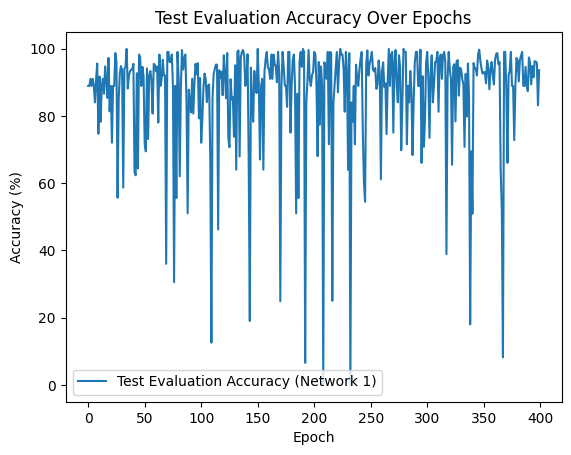

In [ ]:
plt.plot(model.test_eval_accuracy, label="Test Evaluation Accuracy (Network 1)")

# Set labels for x and y axes
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")

# Add title and legend
plt.title("Test Evaluation Accuracy Over Epochs")
plt.legend()


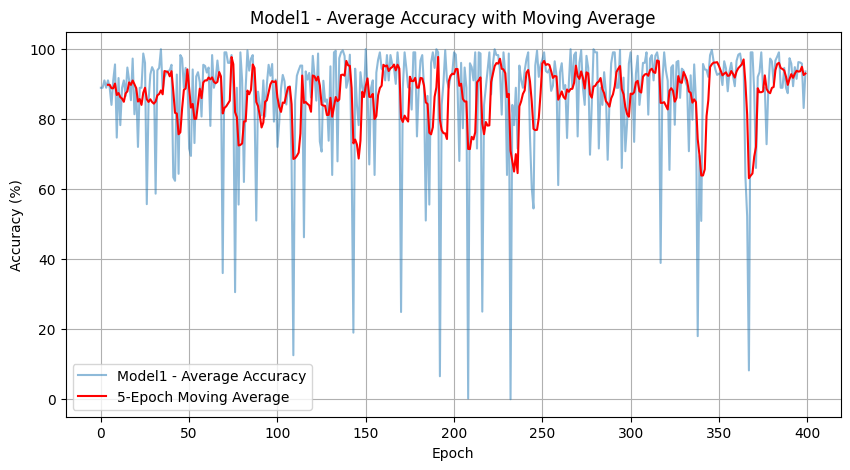

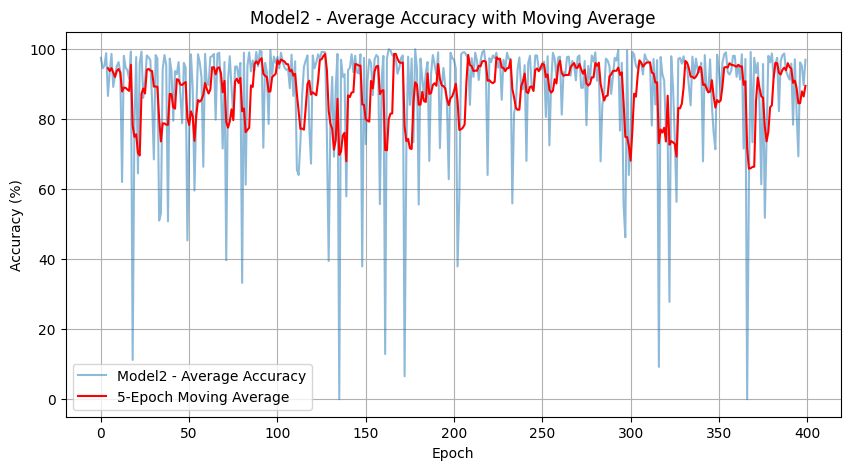

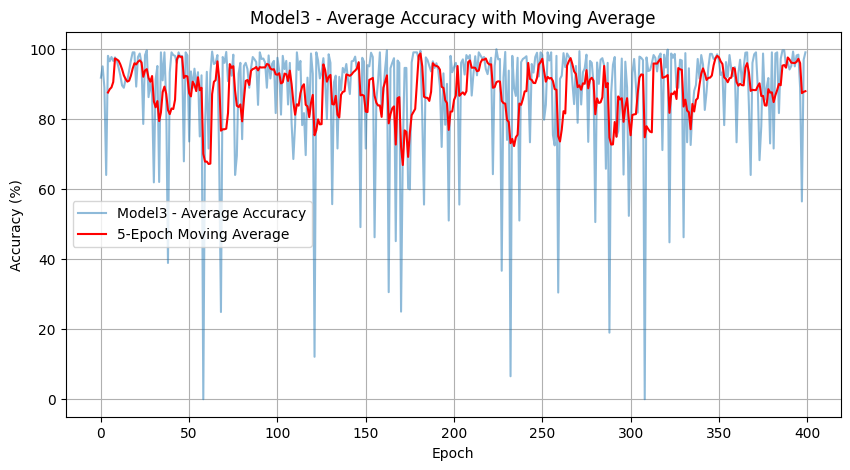

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_moving_average(metric, window_size=5, label='Metric'):
    df = pd.DataFrame(metric, columns=[label])
    df['Moving_Avg'] = df[label].rolling(window=window_size).mean()

    plt.figure(figsize=(10, 5))
    plt.plot(df[label], label=label, alpha=0.5)
    plt.plot(df['Moving_Avg'], label=f'{window_size}-Epoch Moving Average', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title(f'{label} with Moving Average')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_moving_average(model.test_eval_accuracy, label="Model1 - Average Accuracy")
plot_moving_average(model2.test_eval_accuracy, label="Model2 - Average Accuracy")
plot_moving_average(model3.test_eval_accuracy, label="Model3 - Average Accuracy")